# Choosing the Best Plan?

You work as an analyst for the telecommunications operator Megaline. The company offers its customers two prepaid plans: Surf and Ultimate. The marketing department wants to know which plan generates more revenue in order to adjust the advertising budget accordingly.

You will conduct a preliminary analysis of the plans based on a relatively small selection of customers. You’ll have data from 500 Megaline customers, including who they are, where they’re from, which plan they use, as well as the number of calls they made and text messages they sent in 2018.
Your task is to analyze customer behavior and determine which prepaid plan generates the most revenue.

For this project, which consists of several datasets, my approach to the analysis will be as follows:

- Load the necessary libraries and then load the various files for subsequent visualization.
- Perform a general overview of the data types contained in each dataset and check how many non-null entries exist per dataset.
- In case of discrepancies (such as missing, invalid, or duplicate data), proceed with data cleaning to prepare for further analysis.

# 1. Initialization

In [1]:
# Import functions
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats as st
from math import factorial
import seaborn as sns
from matplotlib import pyplot as plt

from src.null_columns import show_null_columns
from src.groupby_month import calculate_user_monthly
from src.plan_info import add_plan_information
from src.revenue_calculation import calculate_revenue

In [ ]:
# Extract the info from the Datasets

df_users = pd.read_csv('../data/raw/df_users.csv')
df_calls = pd.read_csv('../data/raw/df_calls.csv')
df_messages = pd.read_csv('../data/raw/df_messages.csv')
df_internet = pd.read_csv('../data/raw/df_internet.csv')
df_plans = pd.read_csv('../data/raw/df_plans.csv')

# 2. Data Preprocessing
### 2.1 Copy original Dataframes

In [4]:
# Clone datasets to keep the original with no changes
df_plans_clean = df_plans.copy()
df_users_clean = df_users.copy()
df_calls_clean = df_calls.copy()
df_messages_clean = df_messages.copy()
df_internet_clean = df_internet.copy()

### 2.2 Reviewing duplicate / null values
#### 2.2.1 Dataframe Plans

In [5]:
# General View
df_plans.info()
print()
print(df_plans.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10          

In [6]:
# Reordering the column 'plan_name' at the beginning
col = df_plans_clean.pop('plan_name')
df_plans_clean.insert(0, 'plan_name', col)

# Add column "gb_per_month_included" to standardize the included data and the extra data cost
df_plans_clean['gb_per_month_included'] = df_plans_clean['mb_per_month_included'] / 1024
df_plans_clean['gb_per_month_included'] = df_plans_clean['gb_per_month_included'].astype(int)

# Remove column "mb_per_month_included"
del df_plans_clean["mb_per_month_included"]

# Print a sample of the data for the plans
col_gb = df_plans_clean.pop("gb_per_month_included")
df_plans_clean.insert(1, "gb_per_month_included", col_gb)

### 2.2.2 Dataframe Users

In [7]:
# General View
df_users.info()
print()
print(df_users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40       

In [8]:
    # Fixing the DateTypes
# Correct the data type of the "reg_date" and "churn_date" columns to datetime
df_users_clean['reg_date'] = pd.to_datetime(df_users_clean['reg_date'])
df_users_clean['churn_date'] = pd.to_datetime(df_users_clean['churn_date'])

# Rename the "plan" column to match the "plan_name" column in the 'plans' dataset
df_users_clean.rename(columns={"plan": "plan_name"}, inplace=True)

Null Values

In [9]:
show_null_columns(df_users_clean)
print()

"""
Findings:
About the column 'churn_date', the null values can be considered as active users (non-terminated plans).
"""

# Check the number of active and inactive users based on the values in the "churn_date" column
print("Active users:", df_users_clean['churn_date'].isnull().sum())
print("Users who canceled:", df_users_clean['churn_date'].notnull().sum())

# Add a column that identifies whether there is a null or non-null value in the "churn_date" column
df_users_clean["user_active"] = np.where(df_users_clean["churn_date"].isna(), "active", "no active")


Columns with null values in Dataset:
            null_count  null_percent
churn_date         466          93.2

Active users: 466
Users who canceled: 34


Duplicated Values

In [10]:
print('The number of duplicated rows is:', df_users_clean.duplicated().sum())
print('Duplicated IDs:', df_users_clean['user_id'].duplicated().sum())

The number of duplicated rows is: 0
Duplicated IDs: 0


### 2.2.3 Dataframe Calls

In [11]:
# General View
df_calls.info()
print()
print(df_calls.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


In [12]:
"""
Findings:
With the dataframe description, and according to the instructions, the values in the column 'duration' should be expressed in minutes. 
So, the data has to be rounded up. 
Also, column 'call_date' datatype is object, and should be changed to datetime. 
Finally, for better analysis further, I'll add a column per month.
"""
    # Fixing the DateTypes
df_calls_clean['call_date'] = pd.to_datetime(df_calls_clean['call_date'])

# Round call duration (from seconds to minutes) and convert the data type to int
df_calls_clean['duration'] = np.ceil(df_calls_clean['duration']).astype(int)
df_calls_clean['month'] = df_calls_clean['call_date'].dt.month
#df_calls_clean.info()

Duplicated Values

In [13]:
print('The number of duplicated rows is:', df_calls_clean.duplicated().sum())
print('Duplicated IDs:', df_calls_clean['id'].duplicated().sum())

The number of duplicated rows is: 0
Duplicated IDs: 0


Null Values

In [14]:
show_null_columns(df_calls_clean)


Columns with null values in Dataset:
No null values found


### 2.2.4 Dataframe Messages

In [15]:
# General View
df_messages.info()
print()
print(df_messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


In [16]:
"""
Findings:
With the dataframe description, and according to the instructions, the values in the column 'duration' should be expressed in minutes. 
So, the data has to be rounded up. 
Also, column 'call_date' datatype is object, and should be changed to datetime. 
For better analysis further, I'll add a column per month.
"""
    # Fixing the DateTypes
df_messages_clean['message_date'] = pd.to_datetime(df_messages_clean['message_date'])

# Add the "month" column, using the month extracted from "message_date"
df_messages_clean['month'] = df_messages_clean['message_date'].dt.month

Duplicated Values

In [17]:
print('The number of duplicated rows is:', df_messages_clean.duplicated().sum())
print('Duplicated IDs:', df_messages_clean['id'].duplicated().sum())

The number of duplicated rows is: 0
Duplicated IDs: 0


Null Values

In [18]:
show_null_columns(df_messages_clean)


Columns with null values in Dataset:
No null values found


### 2.2.5 Dataframe Internet

In [19]:
# General View
df_internet.info()
print()
print(df_internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


In [20]:
"""
Findings: 
The data type of the "session_date" column appears as an object and must be converted to datetime.
The "mb_used" column, according to the plan descriptions, should first be converted from MB to GB.
Finally, for later monthly analysis, we need to add a new column that extracts the month from "session_date".
"""
# Convert the object data type to datetime
df_internet_clean['session_date'] = pd.to_datetime(df_internet_clean['session_date'])

# Convert "mb" values to "gb" and assign them to a new column "gb_used". Round values and convert to int.
df_internet_clean['gb_used'] = df_internet_clean['mb_used'] / 1024

# Add the "month" column, taking the month from the "session_date" column
df_internet_clean['month'] = df_internet_clean['session_date'].dt.month

Duplicated Values

In [21]:
print('The number of duplicated rows is:', df_internet_clean.duplicated().sum())
print('Duplicated IDs:', df_internet_clean['id'].duplicated().sum())

The number of duplicated rows is: 0
Duplicated IDs: 0


Null Values

In [22]:
show_null_columns(df_internet_clean)


Columns with null values in Dataset:
No null values found


# 3. Studying Plan Conditions

In [23]:
print(df_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


### 3.1 Add data by user 

In [24]:
"""
Here is to calculate the metrics of the user. Calculating:
- The user number of calls made per month
- The user number of minutes used per month
- The user number of messages sent per month
- The user number of data used (GB rounded up) per month
"""
# Using calculate function. 
user_monthly_metrics = calculate_user_monthly(df_calls_clean, df_messages_clean, df_internet_clean)

# Print results
user_monthly_metrics.info()
print()
user_monthly_metrics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         2293 non-null   int64
 1   month           2293 non-null   int32
 2   total_calls     2293 non-null   int64
 3   total_minutes   2293 non-null   int64
 4   total_messages  2293 non-null   int64
 5   total_data_gb   2293 non-null   int64
dtypes: int32(1), int64(5)
memory usage: 98.7 KB



,user_id,month,total_calls,total_minutes,total_messages,total_data_gb
0,1000,12,16,124,11,2
1,1001,8,27,182,30,7
2,1001,9,49,315,44,14
3,1001,10,65,393,53,22
4,1001,11,64,426,36,19


### 3.2 Add plan information 

In [25]:
# Here we add the plan information by user
full_data_info = add_plan_information(user_monthly_metrics, df_users_clean, df_plans_clean)
print(full_data_info.head())

   user_id plan_name  usd_monthly_pay  month  total_calls  total_minutes  \
0     1000  ultimate               70     12           16            124   
1     1001      surf               20      8           27            182   
2     1001      surf               20      9           49            315   
3     1001      surf               20     10           65            393   
4     1001      surf               20     11           64            426   

   total_messages  total_data_gb                                   city  \
0              11              2  Atlanta-Sandy Springs-Roswell, GA MSA   
1              30              7        Seattle-Tacoma-Bellevue, WA MSA   
2              44             14        Seattle-Tacoma-Bellevue, WA MSA   
3              53             22        Seattle-Tacoma-Bellevue, WA MSA   
4              36             19        Seattle-Tacoma-Bellevue, WA MSA   

   minutes_included  messages_included  gb_per_month_included  usd_per_minute  \
0          

### 3.3 Calculate monthly revenue

In [26]:
# Here we calculate the monthly revenue per user
full_data_info['monthly_revenue'] = full_data_info.apply(calculate_revenue, axis=1)
print(full_data_info.head())

   user_id plan_name  usd_monthly_pay  month  total_calls  total_minutes  \
0     1000  ultimate               70     12           16            124   
1     1001      surf               20      8           27            182   
2     1001      surf               20      9           49            315   
3     1001      surf               20     10           65            393   
4     1001      surf               20     11           64            426   

   total_messages  total_data_gb                                   city  \
0              11              2  Atlanta-Sandy Springs-Roswell, GA MSA   
1              30              7        Seattle-Tacoma-Bellevue, WA MSA   
2              44             14        Seattle-Tacoma-Bellevue, WA MSA   
3              53             22        Seattle-Tacoma-Bellevue, WA MSA   
4              36             19        Seattle-Tacoma-Bellevue, WA MSA   

   minutes_included  messages_included  gb_per_month_included  usd_per_minute  \
0          

# 4. Data Visualization
### 4.1 Calls

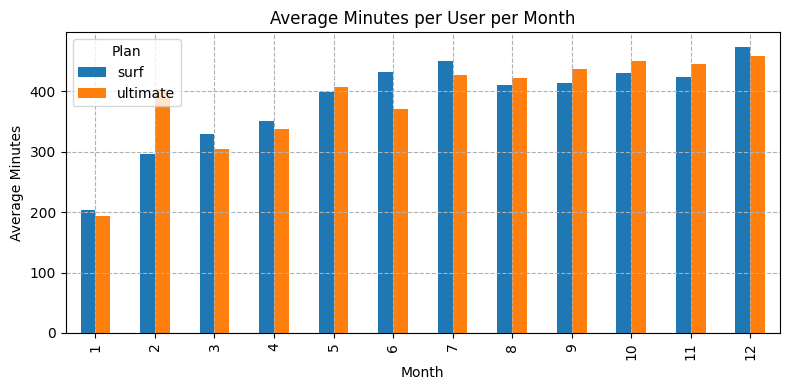

In [30]:
# Compare the average call duration for each plan and for each month.
calls_by_plan = full_data_info.groupby(['plan_name','month'])['total_minutes'].agg(['mean', 'var', 'std']).reset_index()

# Visualization with bar chart.
pivot_calls = calls_by_plan.pivot(index='month', columns='plan_name', values='mean')
pivot_calls.plot(kind='bar', figsize=(8,4), title='Average Minutes per User per Month')
plt.xlabel('Month')
plt.grid(True, linestyle='--')
plt.ylabel('Average Minutes')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

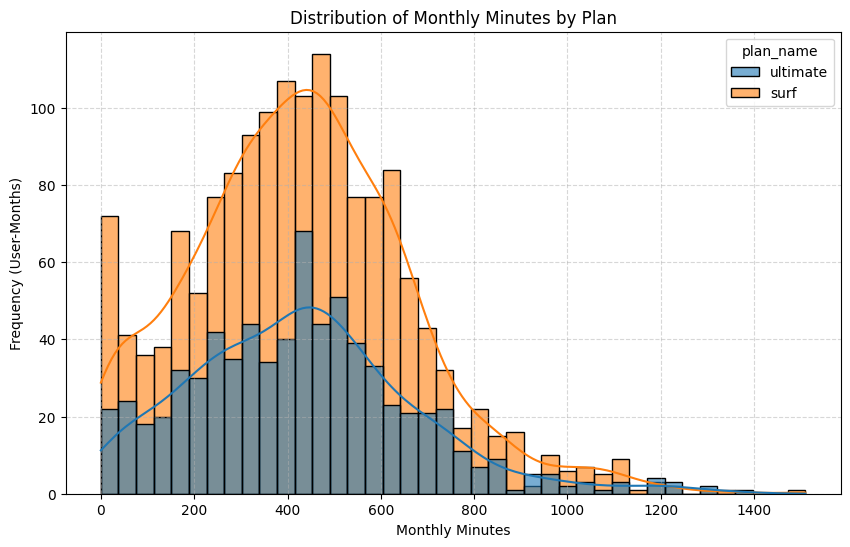

In [33]:
# Compare the number of monthly minutes required by users of each plan.
plt.figure(figsize=(10, 6))

# Visualization
sns.histplot(
    data=full_data_info,
    x='total_minutes',
    hue='plan_name',
    kde=True,
    alpha=0.6,
    bins=40
)

plt.title('Distribution of Monthly Minutes by Plan')
plt.xlabel('Monthly Minutes')
plt.ylabel('Frequency (User-Months)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

           count    mean  median       var     std  min   max
plan_name                                                    
surf        1573  428.75   425.0  54968.28  234.45    0  1510
ultimate     720  430.45   424.0  57844.46  240.51    0  1369


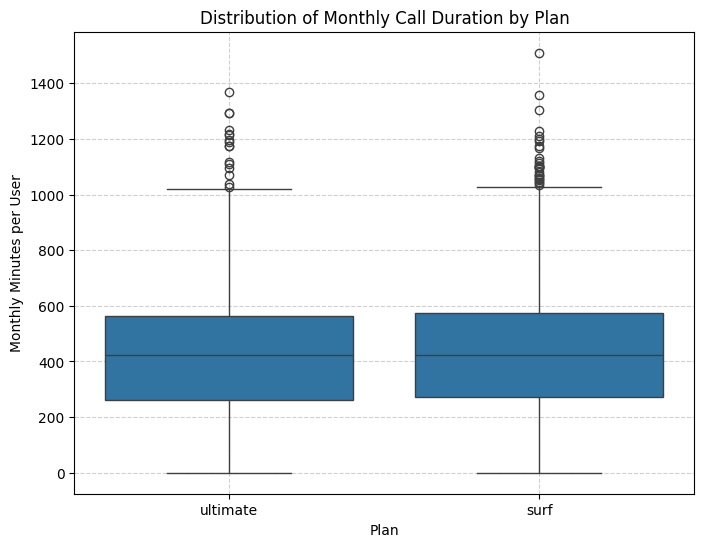

In [34]:
# Calculation of the mean and variance of monthly call duration.
desc_calls = (full_data_info
              .groupby('plan_name')['total_minutes']
              .agg(['count','mean','median','var','std','min','max'])
              .round(2))
print(desc_calls)

# Visualization
plt.figure(figsize=(8, 6))
sns.boxplot(data=full_data_info, x='plan_name', y='total_minutes')
plt.title('Distribution of Monthly Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Monthly Minutes per User')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Findings: <br>
Regarding the variation between users and their plan type, there’s really no noticeable difference. Therefore, I can say that the difference is minimal.

### 4.2 Messages

Descriptive statistics for monthly messages:
           count   mean  median      var    std  min  max
plan_name                                                
surf        1573  31.16    24.0  1126.72  33.57    0  266
ultimate     720  37.55    30.0  1208.76  34.77    0  166


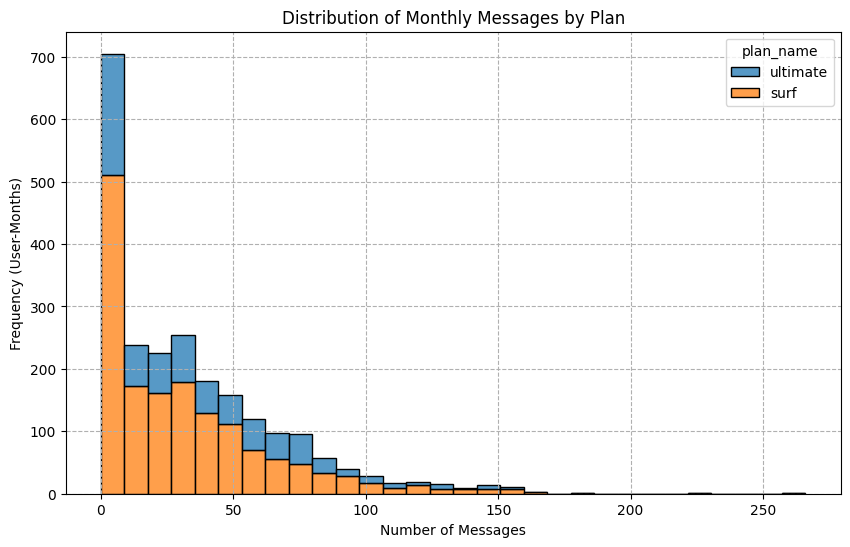

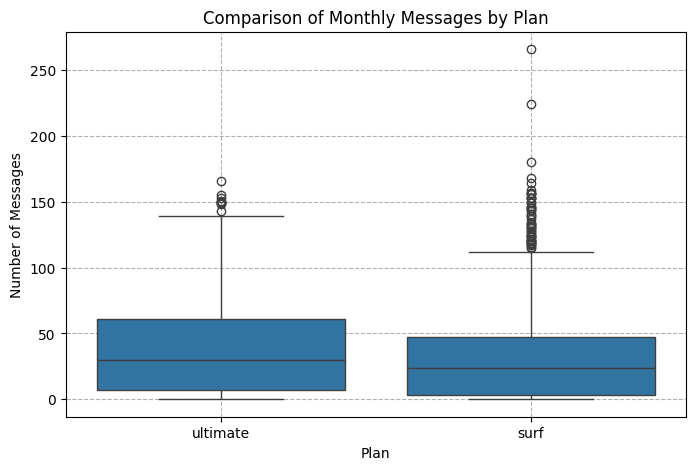

In [38]:
# Compare the number of messages users of each plan tend to send each month
messages_desc = (full_data_info
                 .groupby('plan_name')['total_messages']
                 .agg(['count', 'mean', 'median', 'var', 'std', 'min', 'max'])
                 .round(2))

print("Descriptive statistics for monthly messages:")
print(messages_desc)

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(data=full_data_info, x='total_messages', hue='plan_name', multiple='stack', bins=30)
plt.title('Distribution of Monthly Messages by Plan')
plt.xlabel('Number of Messages')
plt.ylabel('Frequency (User-Months)')
plt.grid(True, linestyle='--')
plt.show()

# Box plot for messages
plt.figure(figsize=(8, 5))
sns.boxplot(data=full_data_info, x='plan_name', y='total_messages')
plt.title('Comparison of Monthly Messages by Plan')
plt.xlabel('Plan')
plt.ylabel('Number of Messages')
plt.grid(True, linestyle='--')
plt.show()

Findings: <br>
Statistically, we can see that on average, users of the Ultimate plan send more messages than those on the Surf plan. <br>
As for the graphs, it can be observed that most users of both plans send fewer than 50 messages — which is the limit for the Surf plan — but for the Ultimate plan, very few users reach their 1,000-message limit.

### 4.3 Internet

Descriptive statistics for monthly GB consumption:
           count   mean  median    var   std  min  max
plan_name                                             
surf        1573  16.67    17.0  61.58  7.85    0   70
ultimate     720  17.31    17.0  58.83  7.67    0   46


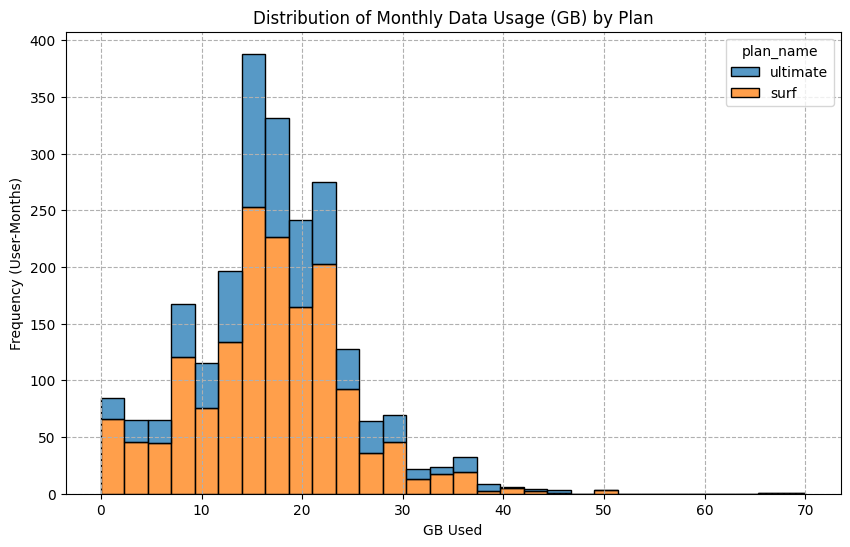

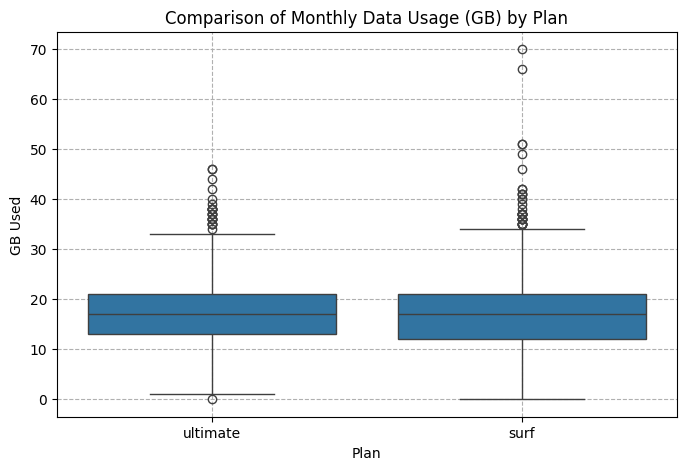

In [40]:
internet_desc = (full_data_info
                 .groupby('plan_name')['total_data_gb']
                 .agg(['count', 'mean', 'median', 'var', 'std', 'min', 'max'])
                 .round(2))

print("Descriptive statistics for monthly GB consumption:")
print(internet_desc)

# Histogram for data usage
plt.figure(figsize=(10, 6))
sns.histplot(data=full_data_info, x='total_data_gb', hue='plan_name', multiple='stack', bins=30)
plt.title('Distribution of Monthly Data Usage (GB) by Plan')
plt.xlabel('GB Used')
plt.ylabel('Frequency (User-Months)')
plt.grid(True, linestyle='--')
plt.show()

# Box plot for data usage
plt.figure(figsize=(8, 5))
sns.boxplot(data=full_data_info, x='plan_name', y='total_data_gb')
plt.title('Comparison of Monthly Data Usage (GB) by Plan')
plt.xlabel('Plan')
plt.ylabel('GB Used')
plt.grid(True, linestyle='--')
plt.show()

Findings: <br>
About internet usage, we can see a greater variation (in proportion to their data limits) among users of both plans. <br>
In the case of Surf, users tend to exceed their included data limit more often, with some reaching up to 70GB. <br>
The users of both plans appear somewhat balanced overall, but considering their limits, it would be worth exploring why Surf customers tend to exceed their data allowance

### 4.4 Revenue

           count   mean  median      var    std   min     max
plan_name                                                    
surf        1573  60.71   40.36  3067.84  55.39  20.0  590.37
ultimate     720  72.31   70.00   129.85  11.40  70.0  182.00


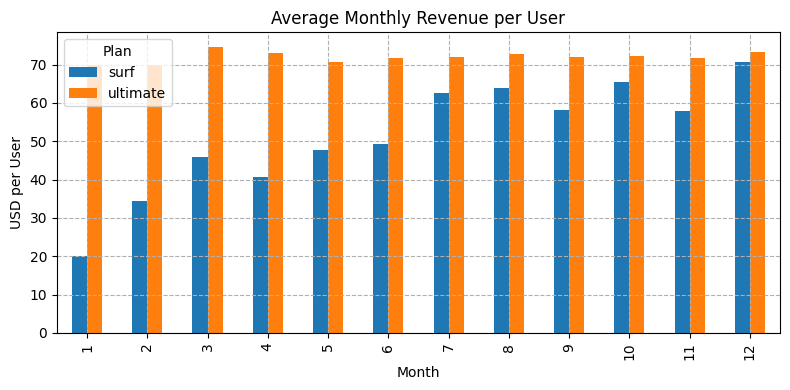

In [42]:
# Statistics by plan
revenue_desc = (full_data_info
                .groupby('plan_name')['monthly_revenue']
                .agg(['count','mean','median','var','std','min','max'])
                .round(2))
print(revenue_desc)

# Separate data by plan
surf_data = full_data_info[full_data_info['plan_name'] == 'surf']
ultimate_data = full_data_info[full_data_info['plan_name'] == 'ultimate']

# Monthly average by plan
revenue_mean = (full_data_info
                .groupby(['plan_name','month'])['monthly_revenue']
                .mean()
                .reset_index())

# Generate a bar chart to visually show the difference between plan types
pivot_rev = revenue_mean.pivot(index='month', columns='plan_name', values='monthly_revenue')
pivot_rev.plot(kind='bar', figsize=(8,4), title='Average Monthly Revenue per User')
plt.xlabel('Month')
plt.ylabel('USD per User')
plt.grid(True, linestyle='--')
plt.legend(title='Plan')
plt.tight_layout()
plt.show()

Findings: <br>
Based on the results of the chart, we could say that the average revenue for the “Ultimate” plan is higher than that of the “Surf” plan, with this difference observed across all months.

# 5. Testing Hypothesis
### Hypothesis 1:
- H₀: The average revenue of users on the Ultimate and Surf plans is equal.
- H₁: The average revenue of users on the Ultimate and Surf plans is different.

In [43]:
# Hypothesis 1

# Extract revenue by plan type
revenue_surf = surf_data['monthly_revenue']
revenue_ultimate = ultimate_data['monthly_revenue']
alpha = 0.05

results = st.ttest_ind(revenue_surf, revenue_ultimate, equal_var=False)
print("Hypothesis Test: Revenue for Ultimate and Surf Plans:")
print('p-value:', results.pvalue)
print()

if results.pvalue < alpha:
    print("We reject the null hypothesis: the average revenue of the plans is significantly different.")
else:
    print("We cannot reject the null hypothesis: there is not enough evidence to say that the average revenue is different.")

Hypothesis Test: Revenue for Ultimate and Surf Plans:
p-value: 3.170390548113574e-15

We reject the null hypothesis: the average revenue of the plans is significantly different.


### Hypothesis 2: 
- H₀: The average revenue of users from NY-NJ is equal to that of users from other regions.
- H₁: The average revenue of users from NY-NJ is different from that of users from other regions.

In [44]:
# Hypothesis 2

# Extract revenue by region
ny_nj_users = full_data_info[full_data_info['city'].str.contains('NY-NJ', case=False)]
other_users = full_data_info[~full_data_info['city'].str.contains('NY-NJ', case=False)]

# Now, separate the revenues by group
revenue_ny_nj = ny_nj_users['monthly_revenue']
revenue_other = other_users['monthly_revenue']
alpha = 0.05

results_region = st.ttest_ind(revenue_ny_nj, revenue_other, equal_var=False)
print("Hypothesis Test: Revenue of NY-NJ Users vs. Other Regions:")
print('p-value:', results_region.pvalue)
print()

if results_region.pvalue < alpha:
    print("We reject the null hypothesis: the average revenue of NY-NJ users is significantly different from that of other regions.")
else:
    print("We cannot reject the null hypothesis: there is not enough evidence to say that the average revenue is different.")

Hypothesis Test: Revenue of NY-NJ Users vs. Other Regions:
p-value: 0.0335256158853001

We reject the null hypothesis: the average revenue of NY-NJ users is significantly different from that of other regions.


Findings of the hypotheses: <br>
Based on the results of this first hypothesis, we can reject the null hypothesis, which suggests that the average revenues of the two existing plans, “Surf” and “Ultimate,” are different.<br>
About the 2nd one, we can reject the null hypothesis, suggesting that the revenues from the NY-NJ region are significantly different from those of other regions.

# 6. Conclusion

The goal of this project was to determine which of the two prepaid plans, Surf or Ultimate, generates higher average revenue per customer for the telecom operator Megaline, in order to guide the advertising budget.

- We began with data preprocessing:

A thorough cleaning and transformation were carried out on data from five different sources (users, calls, messages, internet, and plans).
Key tasks included correcting data types, handling missing values, converting MB to GB, and applying Megaline’s rounding rules for call minutes and monthly data usage.
Consumption data (minutes, messages, GB) were aggregated per user and per month.
Finally, monthly revenue was calculated for each user, considering both the base plan rate and extra charges for exceeding included limits.

- User Behavior Analysis

The behavioral analysis showed that Surf plan users exceed their limits (especially data) much more frequently than Ultimate plan users, resulting in variable but sometimes significant extra-charge revenues.
Ultimate plan users, with higher included limits, rarely incur additional charges, providing more predictable and higher base-rate revenue.
Despite occasional revenue spikes from overages in the Surf plan, the average monthly revenue per user was consistently higher for the Ultimate plan.

- Hypothesis Testing

A Student’s t-test confirmed that the difference in average monthly revenue between the Surf and Ultimate plans is statistically significant.
There was also a statistically significant difference between the average revenues generated by users in the NY-NJ region and those in other regions.

- Final Insight

Although the Surf plan can sometimes generate high individual revenues when users exceed their limits, the Ultimate plan proves to be, on average, more profitable per customer for Megaline.
This finding suggests that the marketing department could focus part of its advertising budget on attracting or retaining Ultimate plan customers, given their higher and more stable contribution to average revenue.